In [161]:
# TensorFlow and tf.keras
import tensorflow as tf

# Helper libraries
import numpy as np
import cv2 
import pandas as pd
import matplotlib.pyplot as plt
from skimage import io, feature, data, color, exposure, transform
from sklearn.model_selection import train_test_split


In [185]:
image_labels = pd.read_csv('dance_label.txt', sep=' ', header=None, names=['image', 'label'])
image_labels = image_labels.to_numpy()
np.unique(image_labels[:, 1], return_counts=True)

(array([0, 1, 2, 3], dtype=object), array([2073,  104,  114,  106]))

In [187]:
import json

def get_joints(file):
    try:
        f = open(file, "r")
    except:
        return

    with f as file:
        loaded_json = json.load(f)
    return loaded_json['people'][0]['pose_keypoints_2d']


In [188]:
X = []
new_image_labels = []
for i, (image, label) in enumerate(image_labels):
    if label == 0 and np.random.random() > 0.3:
        continue
    joints = get_joints(f"openpose_json/{image[:-4]}_keypoints.json")
    if joints is None:
        continue
    X.append({'image': image, 'label': label, 'joints': joints})
    new_image_labels.append([image, label])
X = np.array(X)
new_image_labels = np.array(new_image_labels)

In [191]:
# # Shuffle the data
print(len(X))
indices = np.arange(len(X))
np.random.RandomState(seed=42).shuffle(indices)
X_shuffled = X[indices]
stratify_labels = new_image_labels[indices, 1]

# Data split ratios
train_ratio = 0.8
validation_ratio = 0.1
test_ratio = 0.1

# Split dataset
train_data, temp_data, train_labels, temp_labels = train_test_split(X_shuffled, stratify_labels,
                                                                    test_size=1-train_ratio, stratify=stratify_labels,
                                                                    random_state=42)
validation_data, test_data, validation_labels, test_labels = train_test_split(temp_data,
                                                                              temp_labels,
                                                                              test_size=test_ratio/(test_ratio + validation_ratio),
                                                                              stratify=temp_labels,
                                                                              random_state=42)

952


In [192]:
print(np.unique(train_labels, return_counts=True))
print(np.unique(validation_labels, return_counts=True))
print(np.unique(test_labels, return_counts=True))

(array(['0', '1', '2', '3'], dtype='<U23'), array([502,  83,  91,  85]))
(array(['0', '1', '2', '3'], dtype='<U23'), array([63, 10, 11, 11]))
(array(['0', '1', '2', '3'], dtype='<U23'), array([63, 11, 12, 10]))


In [193]:
def center_at_origin(joints):
    joints = np.array(joints).reshape(25, 3)
    joints[:, 0] -= np.min(joints[:, 0])
    joints[:, 1] -= np.min(joints[:, 1])
    return joints.reshape(75)

In [194]:
def get_XY(data):
    images = []
    X = []
    y = []
    for data_pt in data:
        images.append(data_pt['image'])
        # center_at_origin(data_pt['joints'])
        X.append(center_at_origin(data_pt['joints']))
        y.append(data_pt['label'])
    return images, np.array(X), np.array(y)

train_images, X_train, y_train = get_XY(train_data)
validation_images, X_validation, y_validation = get_XY(validation_data)
test_images, X_test, y_test = get_XY(test_data)

In [154]:
# import matplotlib.pyplot as plt
# import matplotlib.cm as cm
# import matplotlib.animation as animation

# img = []
# frames = [] # for storing the generated images
# fig = plt.figure()
# for i in range(6):
#     frames.append([plt.imshow(img[i], cmap=cm.Greys_r,animated=True)])

# ani = animation.ArtistAnimation(fig, frames, interval=50, blit=True, repeat_delay=1000)
# ani.save('movie.mp4')
# plt.show()


# # importing matplot lib
# import matplotlib.pyplot as plt
# import numpy as np
 
# # importing movie py libraries
# from moviepy.editor import VideoClip
# from moviepy.video.io.bindings import mplfig_to_npimage
 
# # numpy array
# x = np.linspace(-2, 2, 200)
 
# # duration of the video
# duration = 2
 
# # matplot subplot
# fig, ax = plt.subplots()
 
# # method to get frames
# def make_frame(t):
     
#     # clear
#     ax.clear()
     
#     # plotting line
#     ax.plot(x, np.sinc(x**2) + np.sin(x + 2 * np.pi / duration * t), lw = 3)
#     ax.set_ylim(-1.5, 2.5)
     
#     # returning numpy image
#     return mplfig_to_npimage(fig)
 
# # creating animation
# animation = VideoClip(make_frame, duration = duration)
 
# # displaying animation with auto play and looping
# animation.ipython_display(fps = 20, loop = True, autoplay = True)

# import os
# import moviepy.video.io.ImageSequenceClip
# image_folder='folder_with_images'
# fps=1

# image_files = [os.path.join(image_folder,img)
#                for img in os.listdir(image_folder)
#                if img.endswith(".png")]
# clip = moviepy.video.io.ImageSequenceClip.ImageSequenceClip(image_files, fps=fps)
# clip.write_videofile('my_video.mp4')

In [195]:
def create_classification_model(input_shape):
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=input_shape),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dropout(0.2),  # Adding dropout for regularization
        tf.keras.layers.Dense(64, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.1)),
        tf.keras.layers.Dense(4, activation='softmax', kernel_regularizer=tf.keras.regularizers.l2(0.1))  # Output layer with 4 units for 4 labels
    ])
    return model

# Define the input shape
input_shape = (75,)

# Create the model
model = create_classification_model(input_shape)

# Compile the model
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=0.00001)
model.compile(optimizer=optimizer,
              loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

# Print the model summary
model.summary()


Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_58 (Dense)            (None, 128)               9728      
                                                                 
 dropout_22 (Dropout)        (None, 128)               0         
                                                                 
 dense_59 (Dense)            (None, 64)                8256      
                                                                 
 dense_60 (Dense)            (None, 128)               8320      
                                                                 
 dropout_23 (Dropout)        (None, 128)               0         
                                                                 
 dense_61 (Dense)            (None, 64)                8256      
                                                                 
 dense_62 (Dense)            (None, 4)               

In [196]:
model.fit(X_train, y_train, epochs=500, batch_size=32, validation_data=(X_validation, y_validation))

Epoch 1/500
24/24 [==============================] - 0s 4ms/step - loss: 232.8184 - accuracy: 0.1827 - val_loss: 183.3640 - val_accuracy: 0.1158
Epoch 2/500
24/24 [==============================] - 0s 1ms/step - loss: 208.1669 - accuracy: 0.1945 - val_loss: 153.5570 - val_accuracy: 0.1684
Epoch 3/500
24/24 [==============================] - 0s 1ms/step - loss: 185.8972 - accuracy: 0.2300 - val_loss: 127.8845 - val_accuracy: 0.2632
Epoch 4/500
24/24 [==============================] - 0s 1ms/step - loss: 168.6879 - accuracy: 0.2746 - val_loss: 107.8695 - val_accuracy: 0.3158
Epoch 5/500
24/24 [==============================] - 0s 2ms/step - loss: 154.8219 - accuracy: 0.3154 - val_loss: 92.6165 - val_accuracy: 0.3368
Epoch 6/500
24/24 [==============================] - 0s 2ms/step - loss: 144.4055 - accuracy: 0.3259 - val_loss: 80.8414 - val_accuracy: 0.3789
Epoch 7/500
24/24 [==============================] - 0s 2ms/step - loss: 139.5020 - accuracy: 0.3679 - val_loss: 73.8316 - val_accur

In [197]:
classifications = ['None', 'Grand Jete', 'Arabesque', 'Passe']
def visualize_results(type: str, num_visualize=10, random_visualize=False):
    if type == "test":
        X = X_test
        images = test_images
        y = y_test
    elif type == "validation":
        X = X_validation
        images = validation_images
        y = y_validation
    elif type == "training":
        X = X_train
        images = train_images
        y = y_train

    if random_visualize:
        indices = np.random.permutation(len(X))[:num_visualize]
    else:
        indices = np.arange(num_visualize)

    y_est = model.predict(X)
    model.evaluate(X, y)

    # print(y_true.shape)
    for i in indices:
        image = images[i]
        classification = y_est[i]
        label = f"Guess: {classifications[np.argmax(classification)]}, True: {classifications[y[i]]}"
        img = io.imread(f"openpose_output/{image[:-4]}_rendered.jpg")
        plt.imshow(img, cmap='gray')
        plt.axis('off')  # Turn off axis labels
        plt.text(0.5, -0.1, label, ha='center', va='center', transform=plt.gca().transAxes)
        plt.show()

In [204]:
model.save_weights('./dance_checkpoints/arabesque_chuyi_ftw')

3/3 [==============================] - 0s 1ms/step - loss: 25.9102 - accuracy: 0.7188


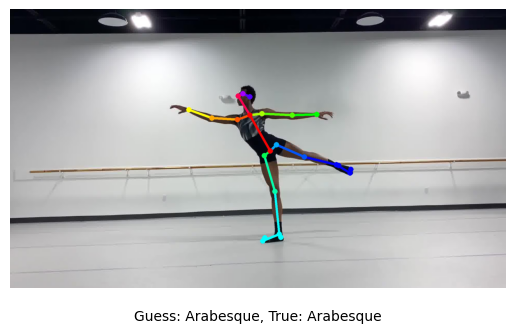

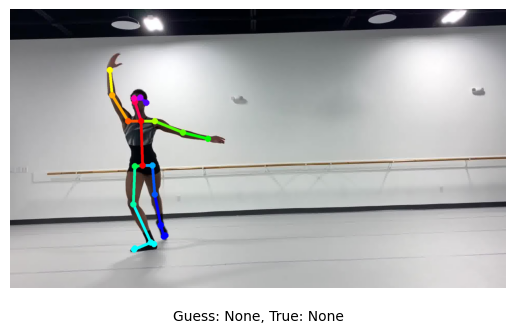

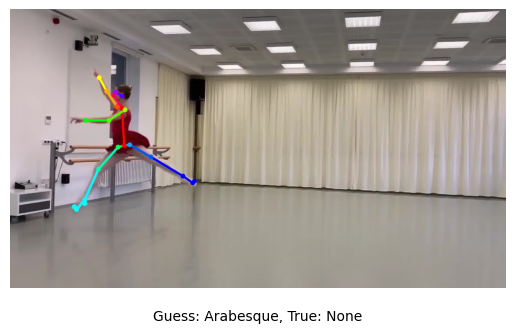

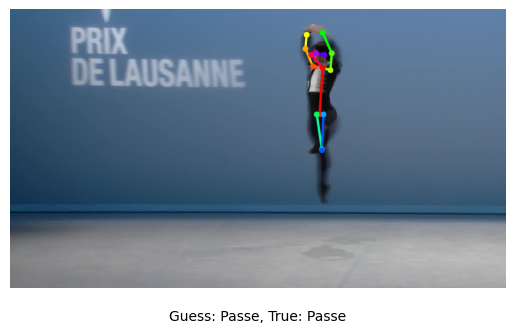

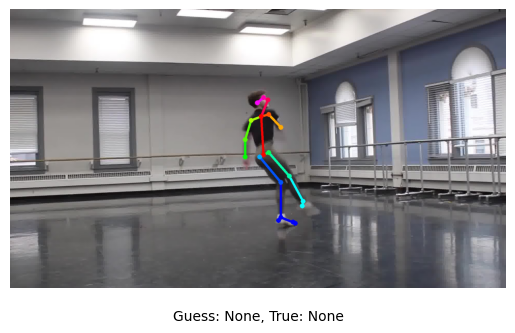

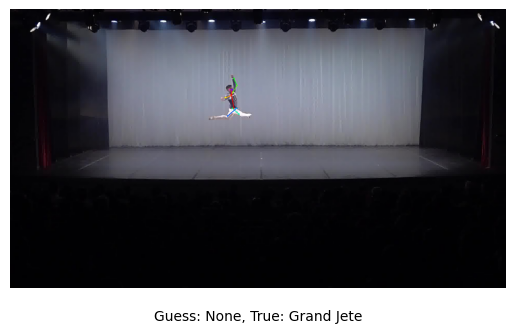

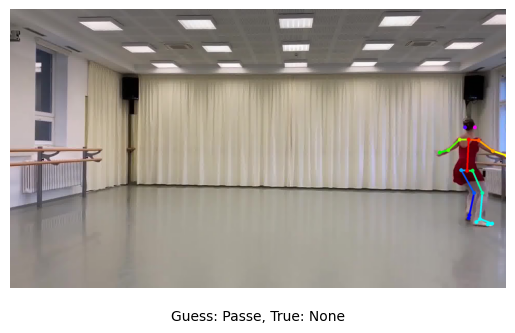

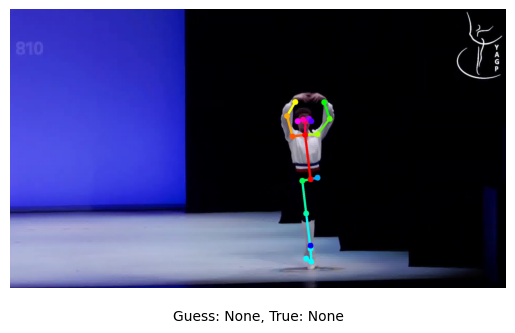

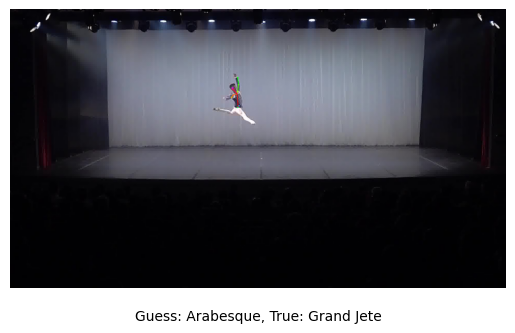

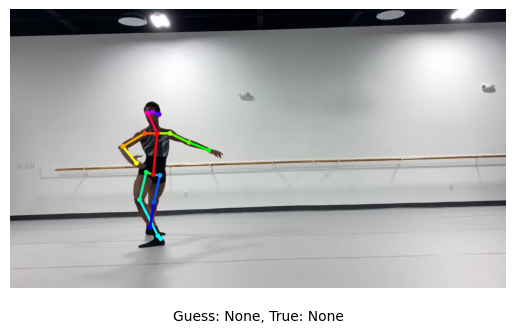

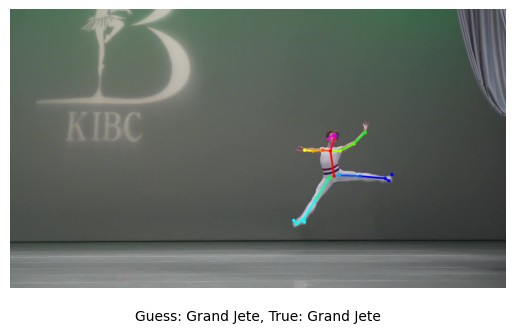

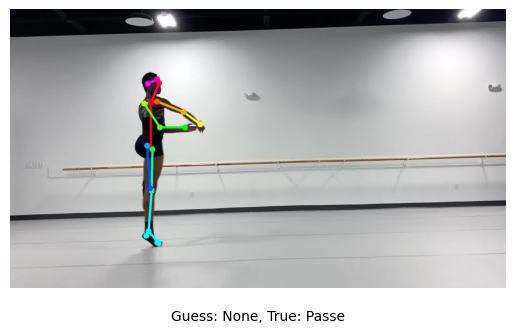

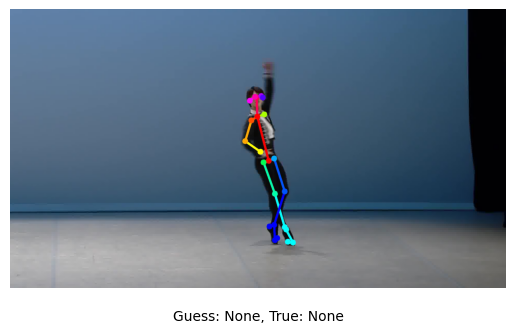

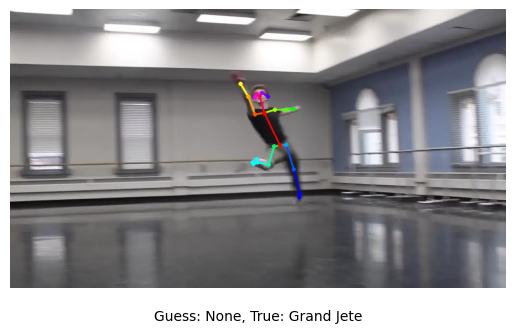

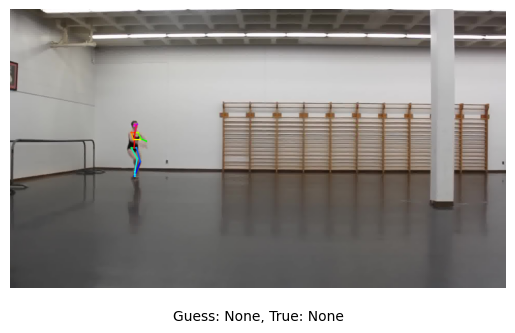

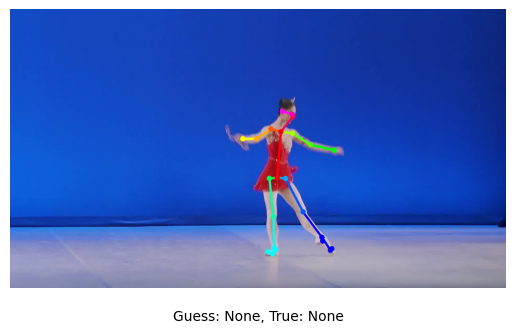

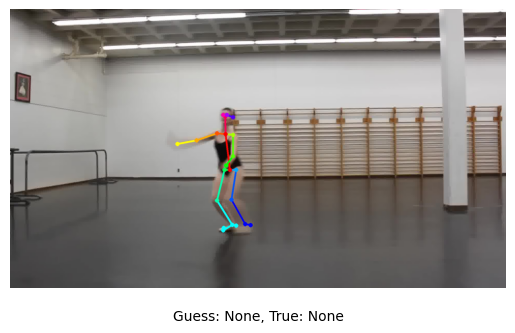

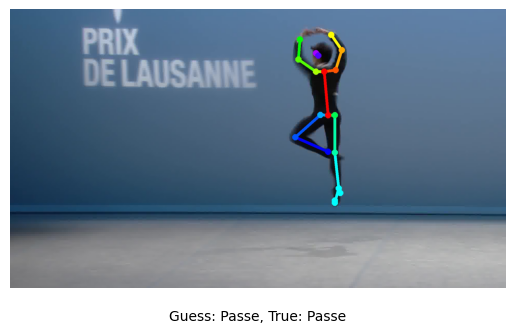

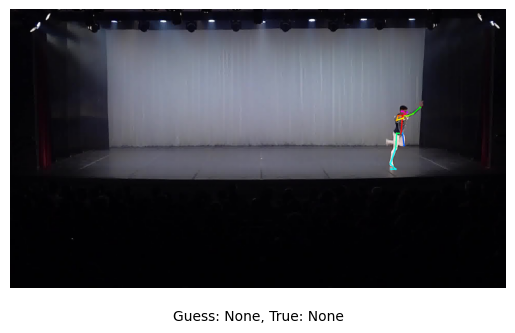

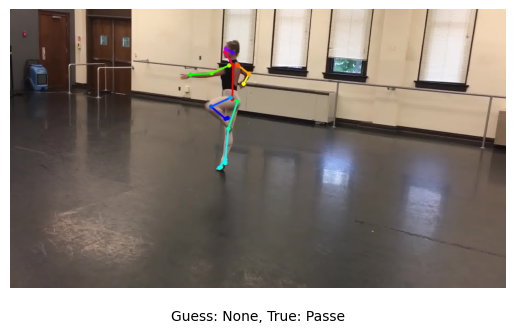

In [198]:
visualize_results("test", random_visualize=True, num_visualize=20)

justin_pirouette
1/1 [==============================] - 0s 12ms/step
[[9.2693305e-01 1.0919289e-05 7.2506621e-02 5.4932816e-04]]


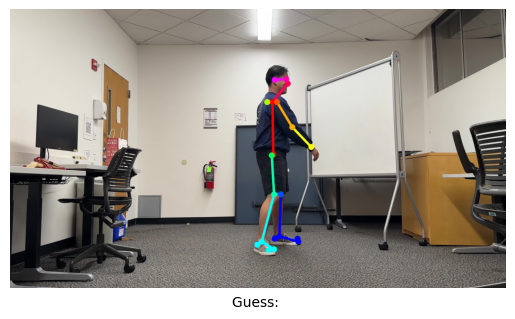

1/1 [==============================] - 0s 15ms/step
[[9.9756491e-01 1.1076508e-05 2.4164543e-03 7.5565767e-06]]


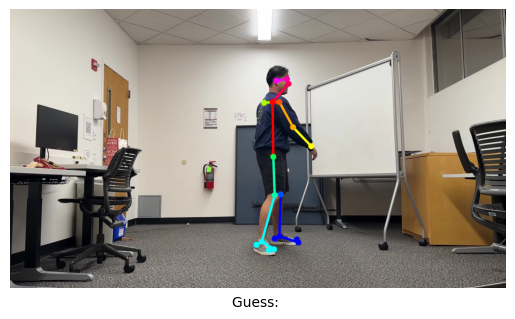

1/1 [==============================] - 0s 13ms/step
[[9.92429793e-01 4.81208262e-05 7.50705088e-03 1.50517335e-05]]


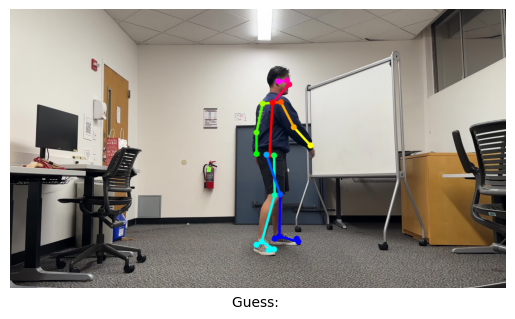

1/1 [==============================] - 0s 12ms/step
[[9.9630642e-01 2.7383378e-05 3.6434075e-03 2.2786211e-05]]


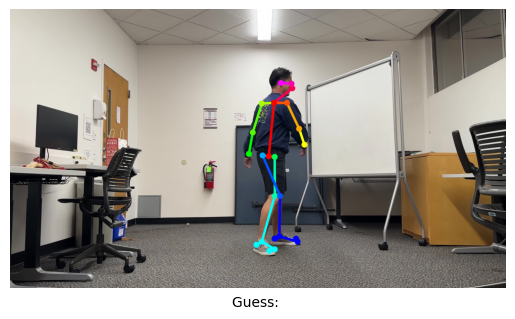

1/1 [==============================] - 0s 11ms/step
[[9.9743372e-01 2.4333987e-05 2.5136329e-03 2.8245691e-05]]


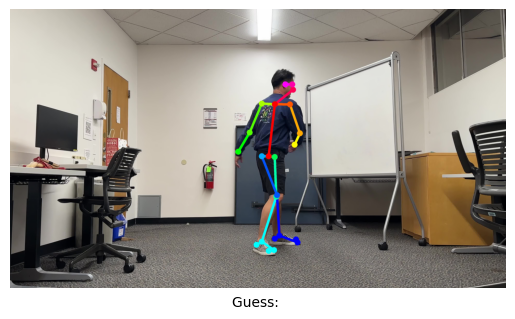

1/1 [==============================] - 0s 11ms/step
[[9.9802703e-01 2.1843831e-05 1.9245942e-03 2.6514324e-05]]


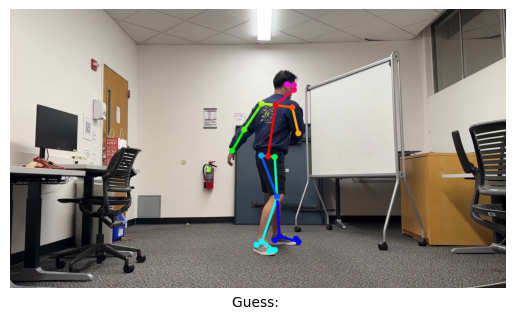

1/1 [==============================] - 0s 12ms/step
[[9.9812406e-01 1.2598597e-05 1.8479750e-03 1.5389280e-05]]


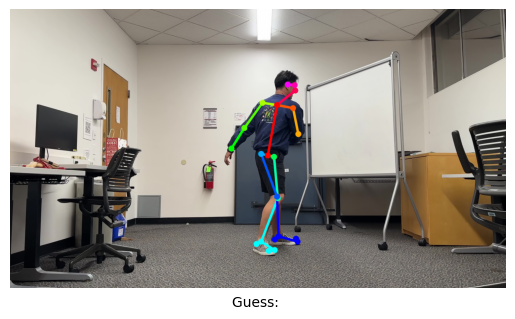

1/1 [==============================] - 0s 12ms/step
[[9.9772853e-01 2.0222102e-05 2.2239168e-03 2.7329261e-05]]


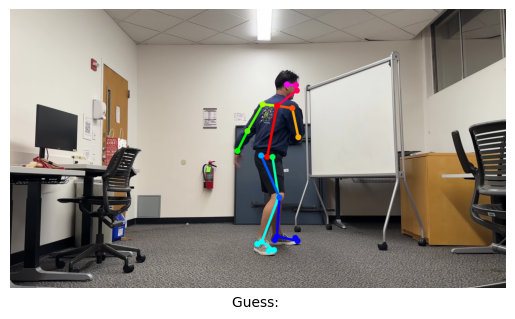

1/1 [==============================] - 0s 11ms/step
[[9.3822575e-01 1.0453581e-03 6.0692936e-02 3.6052112e-05]]


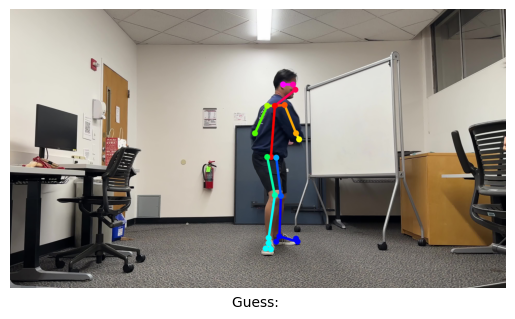

1/1 [==============================] - 0s 11ms/step
[[9.6748269e-01 4.7926072e-04 3.1933643e-02 1.0440609e-04]]


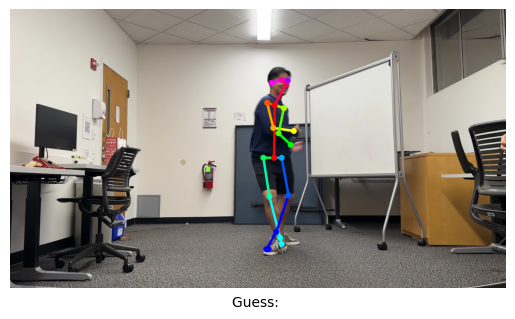

1/1 [==============================] - 0s 11ms/step
[[5.6419122e-01 1.0662454e-03 4.3474257e-01 7.5872253e-10]]


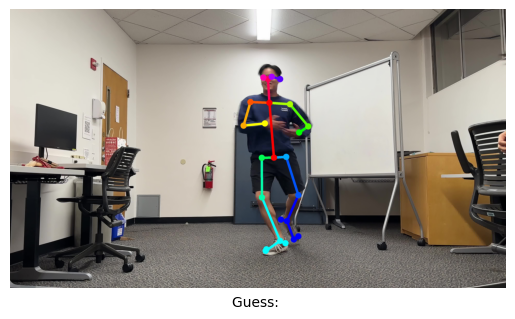

1/1 [==============================] - 0s 12ms/step
[[8.6443281e-01 2.3936216e-05 1.3554333e-01 1.6808488e-10]]


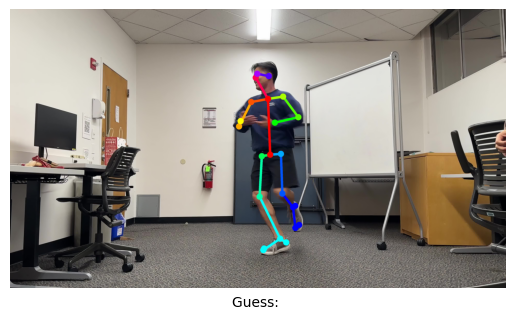

1/1 [==============================] - 0s 12ms/step
[[9.2584729e-01 2.1434813e-08 7.4152701e-02 4.9434954e-09]]


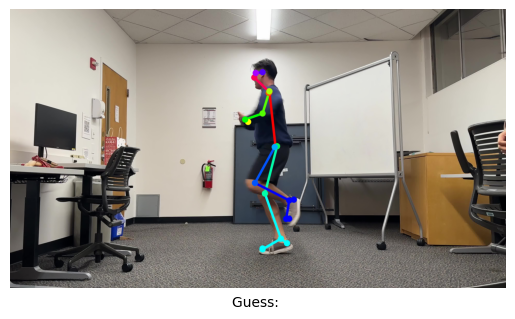

1/1 [==============================] - 0s 13ms/step
[[3.1884426e-01 6.7043602e-01 1.0719684e-02 6.3263379e-08]]


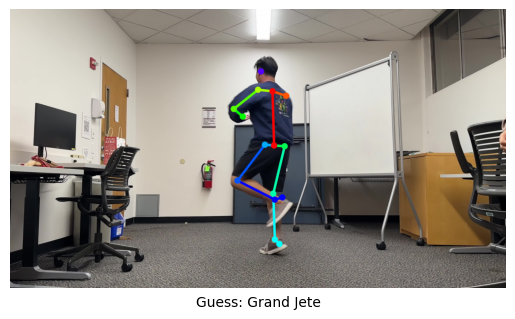

1/1 [==============================] - 0s 11ms/step
[[5.4632354e-01 4.4103572e-01 1.2581980e-02 5.8776353e-05]]


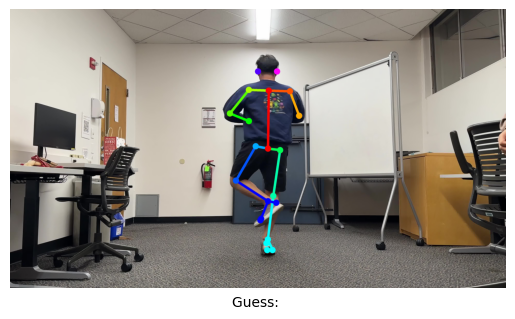

1/1 [==============================] - 0s 11ms/step
[[0.35438752 0.63535714 0.00952289 0.00073236]]


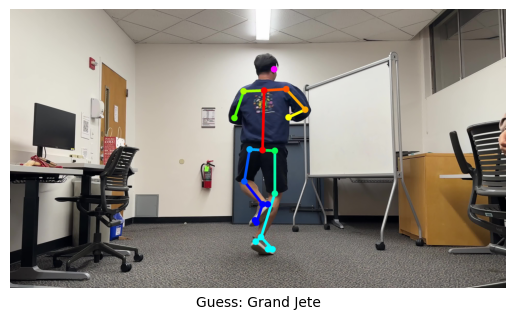

1/1 [==============================] - 0s 11ms/step
[[8.3005196e-01 2.6606099e-06 1.6024259e-01 9.7027821e-03]]


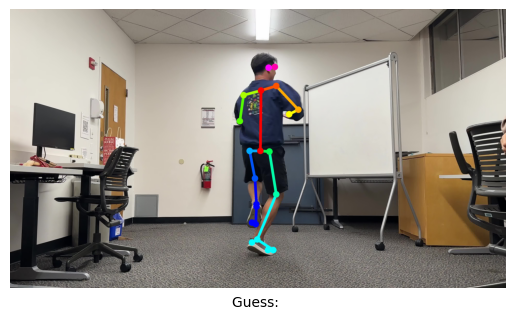

1/1 [==============================] - 0s 24ms/step
[[9.5784050e-01 3.2101507e-05 4.2120099e-02 7.3703109e-06]]


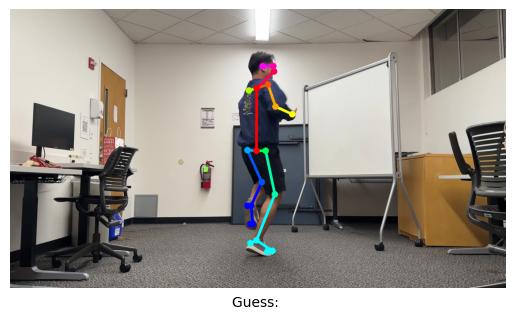

1/1 [==============================] - 0s 13ms/step
[[9.7846413e-01 1.8855018e-05 2.1512214e-02 4.6798068e-06]]


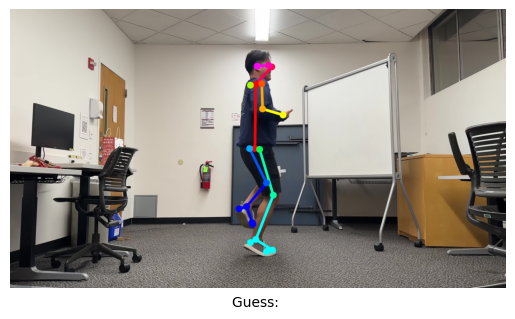

1/1 [==============================] - 0s 12ms/step
[[9.4521922e-01 2.0138721e-03 5.2330930e-02 4.3597171e-04]]


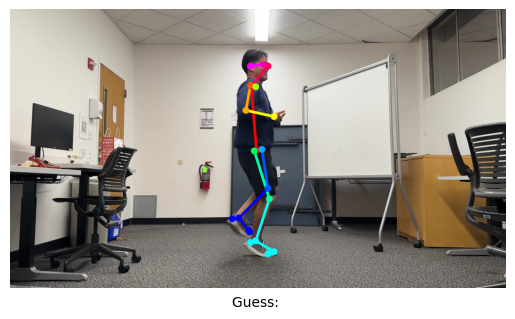

1/1 [==============================] - 0s 10ms/step
[[9.4809920e-01 2.2643122e-04 5.1662039e-02 1.2364853e-05]]


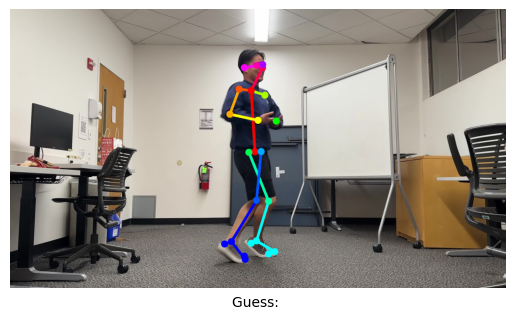

1/1 [==============================] - 0s 15ms/step
[[9.8801649e-01 4.6509260e-05 1.1933277e-02 3.7094719e-06]]


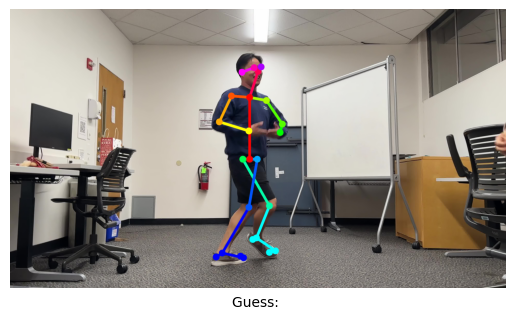

1/1 [==============================] - 0s 14ms/step
[[9.9524951e-01 8.3286366e-05 4.6655098e-03 1.6620671e-06]]


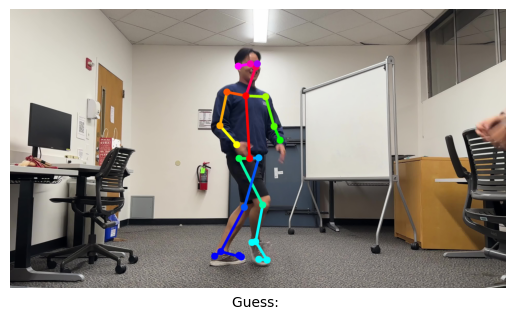

In [210]:
infer_images = []
X_infer = []
base = "justin_pirouette"
num_frames = 23
label_confidences = []
print(base)
for i in range(1,num_frames+1):
    base_image = f"{base}_{i}"
    joints = get_joints(f"dance_predictions/{base}/json/{base_image}_keypoints.json")
    if joints is None:
        continue
    label_confidences = model.predict(np.expand_dims(joints, axis=0))
    classification = classifications[np.argmax(label_confidences)]
    print(label_confidences)
    if classification == "None":
        label = "Guess: "
    else:
        label = f"Guess: {classification}"
    img = io.imread(f"dance_predictions/{base}/output/{base_image}_rendered.jpg")
    plt.imshow(img, cmap='gray')
    plt.axis('off')  # Turn off axis labels
    plt.text(0.5, -0.05, label, ha='center', va='center', transform=plt.gca().transAxes)
    plt.savefig(f"dance_predictions/{base}/processed/{base_image}.jpg")
    plt.show()